In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [56]:
# Read the relevant data files
data_path = '/Users/crishnagarkar/Documents/R STATS/simulacrum_release_v1.2.0.2017/data/'
patients = pd.read_csv(data_path + 'sim_av_patient.csv')
tumors = pd.read_csv(data_path + 'sim_av_tumour.csv', low_memory=False)
outcomes = pd.read_csv(data_path + 'sim_sact_outcome.csv', na_values=[' ', ''])
regimens = pd.read_csv(data_path + 'sim_sact_regimen.csv', na_values=[' ', ''])



In [15]:
# Merge the patient and tumor data frames
data = pd.merge(patients, tumors, left_on='LINKNUMBER', right_on='LINKNUMBER', how='inner')



In [62]:
data = pd.merge(data, regimens, left_on=['TUMOURID', 'PATIENTID_y'], right_on=['MERGED_TUMOUR_ID', 'MERGED_PATIENT_ID'], how='left')
data = pd.merge(data, outcomes, on=['MERGED_TUMOUR_ID', 'MERGED_REGIMEN_ID', 'MERGED_PATIENT_ID'], how='left')


In [16]:
# Handle missing values (if any) in the relevant columns
data = data.dropna(subset=['SITE_ICD10_O2', 'AGE', 'SEX_x', 'ETHNICITY', 'CREG_CODE', 'NEWVITALSTATUS'])



/var/folders/rf/rrll67zx03146l9_xq4c_9lc0000gn/T/ipykernel_53313/749135098.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancer_sites.index, y=cancer_sites.values, palette='viridis')


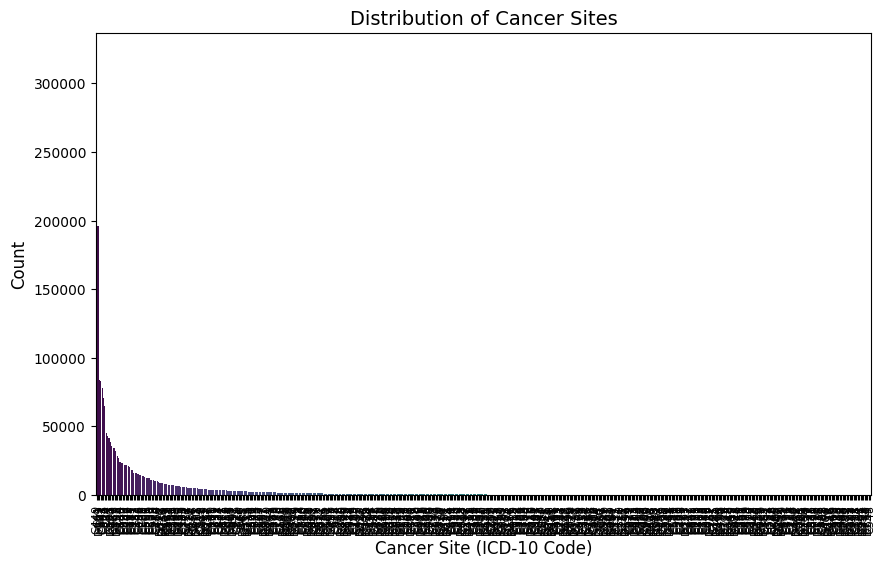

In [46]:
# 1. Distribution of cancer sites
cancer_sites = data['SITE_ICD10_O2'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=cancer_sites.index, y=cancer_sites.values, palette='viridis')
plt.xlabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Cancer Sites', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.show()


/var/folders/rf/rrll67zx03146l9_xq4c_9lc0000gn/T/ipykernel_53313/634633331.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cancer_sites.index, y=top_cancer_sites.values, palette='viridis_r')


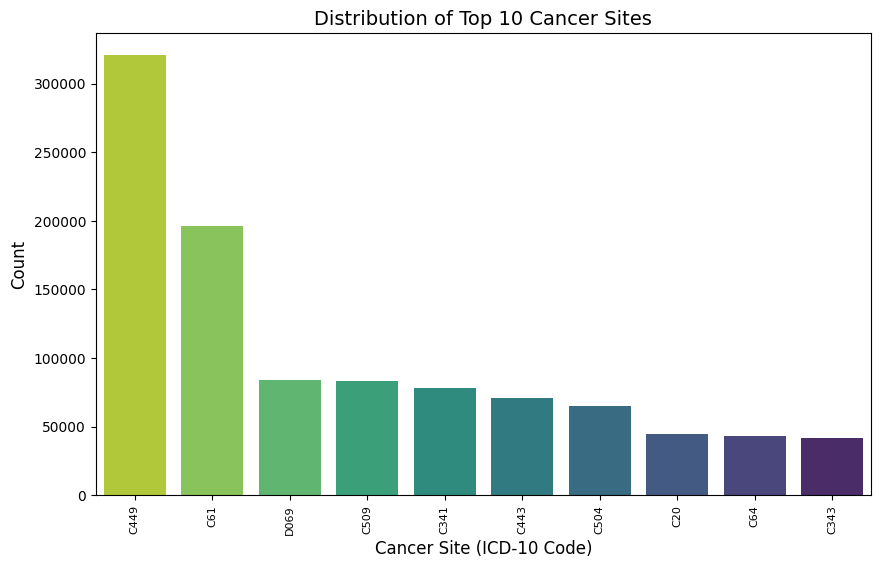

In [32]:
# Exploratory Data Analysis

# 1. Distribution of cancer sites
top_x = 10  # Define the number of top cancer sites you want to visualize
top_cancer_sites = data['SITE_ICD10_O2'].value_counts().head(top_x)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_cancer_sites.index, y=top_cancer_sites.values, palette='viridis_r')
plt.xlabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Distribution of Top {top_x} Cancer Sites', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.show()


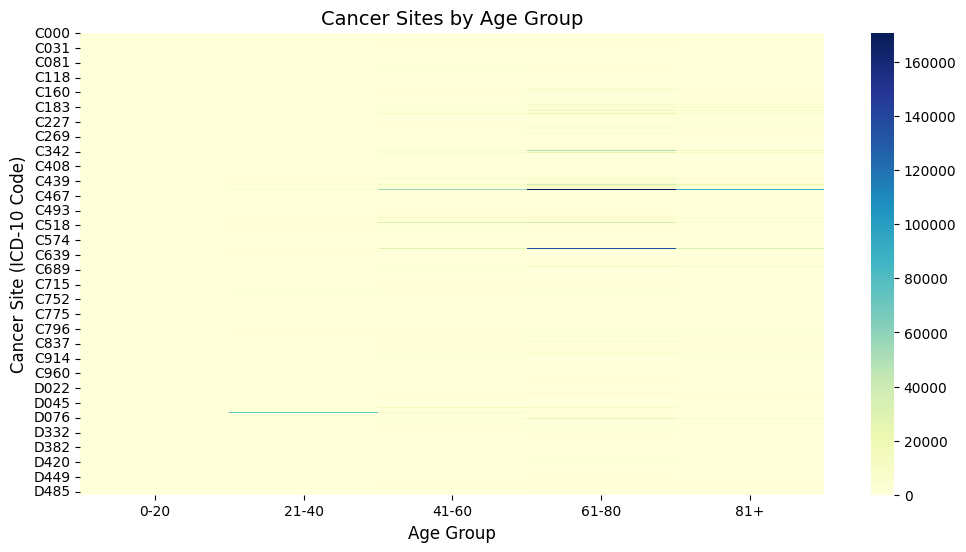

In [47]:
# 2. Cancer sites by age group
age_groups = ['0-20', '21-40', '41-60', '61-80', '81+']
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=[-1, 20, 40, 60, 80, 120], labels=age_groups)

cancer_sites_by_age = data.groupby(['SITE_ICD10_O2', 'AGE_GROUP'])['LINKNUMBER'].count().unstack('AGE_GROUP')

plt.figure(figsize=(12, 6))
sns.heatmap(cancer_sites_by_age, annot=False, cmap='YlGnBu')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.title('Cancer Sites by Age Group', fontsize=14)
plt.show()


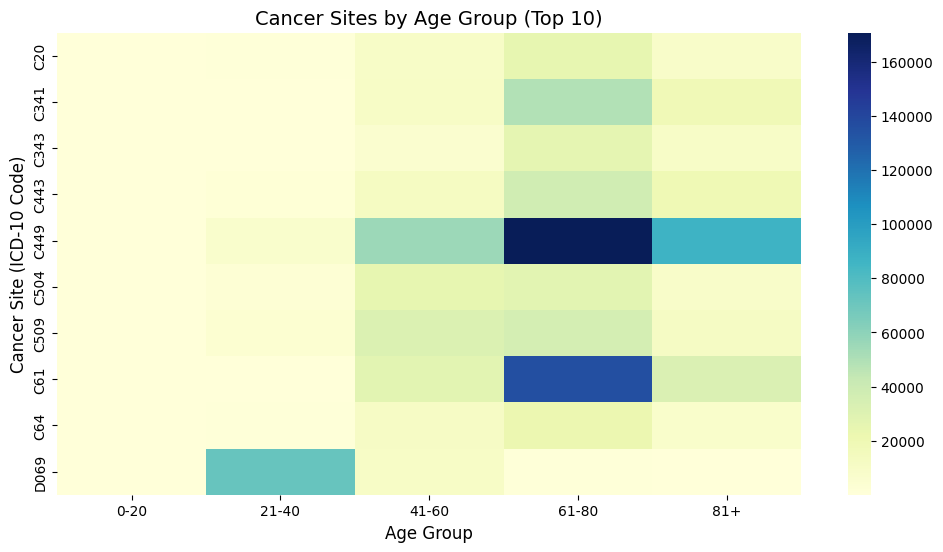

In [40]:
# 2. Cancer sites by age group (top 10 most prevalent cancer sites)
age_groups = ['0-20', '21-40', '41-60', '61-80', '81+']
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=[-1, 20, 40, 60, 80, 120], labels=age_groups)

# Get the top 10 most prevalent cancer sites
top_cancer_sites = data['SITE_ICD10_O2'].value_counts().head(10).index

# Filter the data for the top 10 cancer sites
data_top_sites = data[data['SITE_ICD10_O2'].isin(top_cancer_sites)]

# Plot the data for the top 10 cancer sites
cancer_sites_by_age = data_top_sites.groupby(['SITE_ICD10_O2', 'AGE_GROUP'])['LINKNUMBER'].count().unstack('AGE_GROUP')

plt.figure(figsize=(12, 6))
sns.heatmap(cancer_sites_by_age, annot=False, cmap='YlGnBu')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.title('Cancer Sites by Age Group (Top 10)', fontsize=14)
plt.show()


In [36]:
# Check the columns in cancer_sites_by_sex
print(cancer_sites_by_sex.columns)


Index([1, 2, 9], dtype='int64', name='SEX_x')


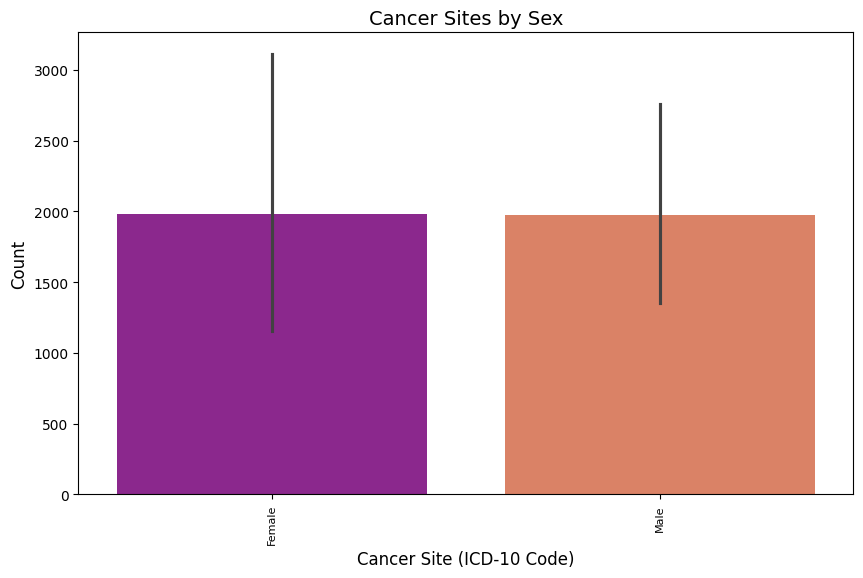

In [41]:
# 3. Cancer Sites by Sex
cancer_sites_by_sex = data.groupby(['SITE_ICD10_O2', 'SEX_x'])['LINKNUMBER'].count().unstack('SEX_x')

# Select only Female and Male columns
cancer_sites_by_sex = cancer_sites_by_sex[[1, 2]]

# Rename the columns
cancer_sites_by_sex.columns = ['Female', 'Male']

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=cancer_sites_by_sex, palette='plasma')
plt.xlabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Cancer Sites by Sex', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.show()


In [43]:
num_geographical_regions = data['CREG_CODE'].nunique()
print("Number of geographical regions (CREG_CODE values):", num_geographical_regions)


Number of geographical regions (CREG_CODE values): 8


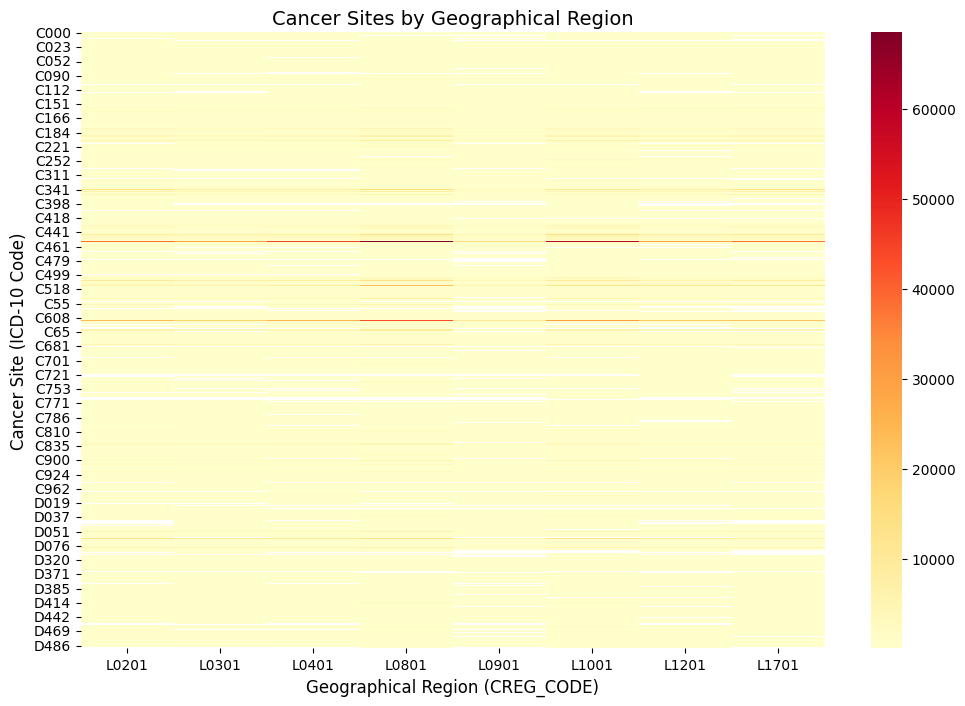

In [50]:
# 4. Cancer sites by geographical region (using CREG_CODE as a proxy)
cancer_sites_by_region = data.groupby(['SITE_ICD10_O2', 'CREG_CODE'])['LINKNUMBER'].count().unstack('CREG_CODE')

plt.figure(figsize=(12, 8))
sns.heatmap(cancer_sites_by_region, annot=False, cmap='YlOrRd')
plt.xlabel('Geographical Region (CREG_CODE)', fontsize=12)
plt.ylabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.title('Cancer Sites by Geographical Region', fontsize=14)
plt.show()


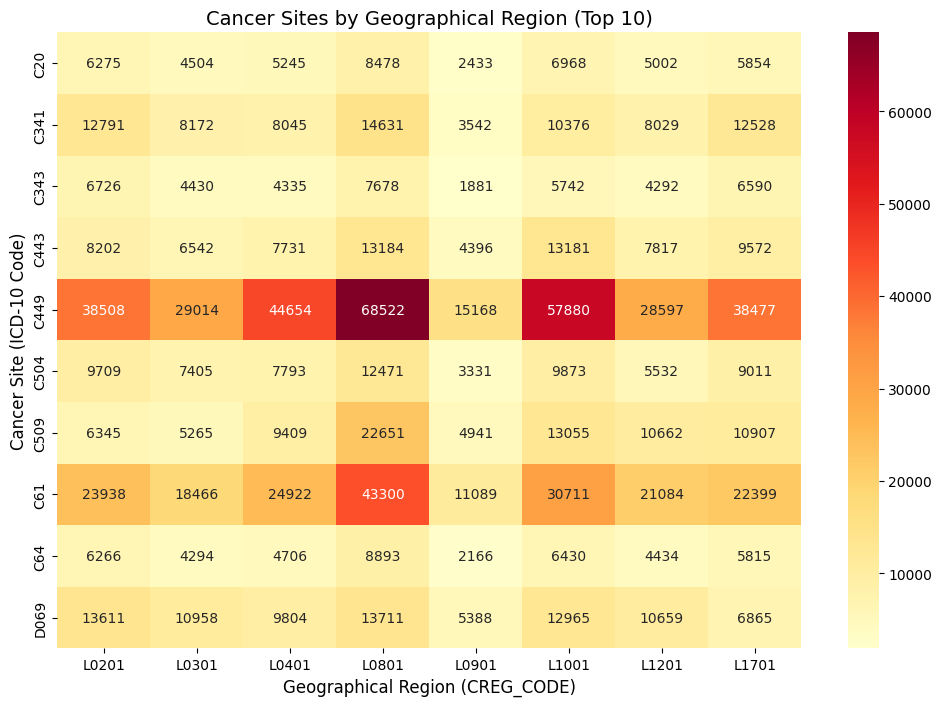

In [45]:
# 4. Cancer sites by geographical region (using CREG_CODE as a proxy)
# Get the top 10 most prevalent cancer sites
top_cancer_sites = data['SITE_ICD10_O2'].value_counts().head(10).index

# Get the top 10 most prevalent geographical regions
top_regions = data['CREG_CODE'].value_counts().head(10).index

# Filter the data for the top 10 cancer sites and top 10 geographical regions
data_top_sites_regions = data[(data['SITE_ICD10_O2'].isin(top_cancer_sites)) & (data['CREG_CODE'].isin(top_regions))]

# Plot the data for the top 10 cancer sites and top 10 geographical regions
cancer_sites_by_region = data_top_sites_regions.groupby(['SITE_ICD10_O2', 'CREG_CODE'])['LINKNUMBER'].count().unstack('CREG_CODE')

plt.figure(figsize=(12, 8))
sns.heatmap(cancer_sites_by_region, annot=True, cmap='YlOrRd', fmt='d')
plt.xlabel('Geographical Region (CREG_CODE)', fontsize=12)
plt.ylabel('Cancer Site (ICD-10 Code)', fontsize=12)
plt.title('Cancer Sites by Geographical Region (Top 10)', fontsize=14)
plt.show()
